# MEDimage Tutorial − Initiation to the MEDimage class

@Author : [MEDomics consortium](https://github.com/medomics/)

@Email : medomics.info@gmail.com


**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

This package is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This package is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this package.  If not, see <http://www.gnu.org/licenses/>.

## Introduction


This notebook is a tutorial for the *MEDimage* class to give a detailed introduction & explanation on the Python class. The *MEDimage* class is the main object used in the *MEDimage* package either when it comes to processing, features extraction or any other type of image analysis. It offers many attributes, child classes and many methods. This makes the *MEDimage* package an excellent tool for radiomics studies. 

Our *MEDimage* tutorial will guide you to learn everything you need about the *MEDimage* class.


The idea behind the *MEDimage* class was to convert an equivalent of the radiomics study scheme flowchart (Figure below) into a Python object.

<img src="https://ibsi.readthedocs.io/en/latest/_images/Processing_simplifiedv6.png" alt="Flowchart of radiomics study scheme" style="width:650px;"/>

And using the Python new objects (*MEDimage* and its children), we get the following flowchart

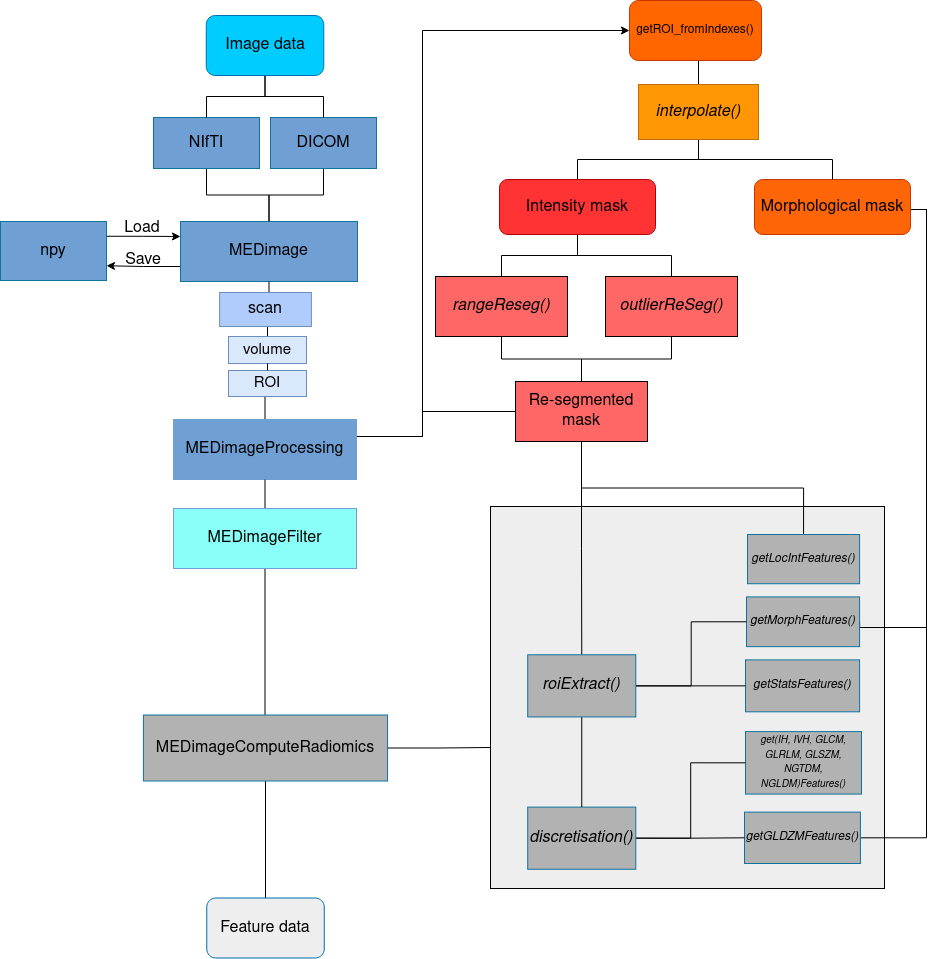

As the figures show, the *MEDimage* class is the main pillar for the *MEDimage* package architecture.

The *MEDimage* class attributes are usually data extracted from imaging data headers (DICOM header, NIfTI header...) and used for processing and computation. In addition to the attributes, the *MEDimage* class contains different class methods that are also used for the same purposes as the attributes. Finally, *MEDimage* have two sub-classes *MEDimageProcessing* and *MEDimageComputeRadiomics*. *MEDimageProcessing* is a class that inherits directly from *MEDimage* and offers many processing methods with different algorithms that are usually called before features extraction. Next, *MEDimageComputeRadiomics* inherits from *MEDimageProcessing* and offers all the computation methods needed for features extraction.

To further understand the *MEDimage* class and its children, take a look at the class diagram below that describes the structure of the *MEDimage* class, its attributes, methods and the relationships among other objects.

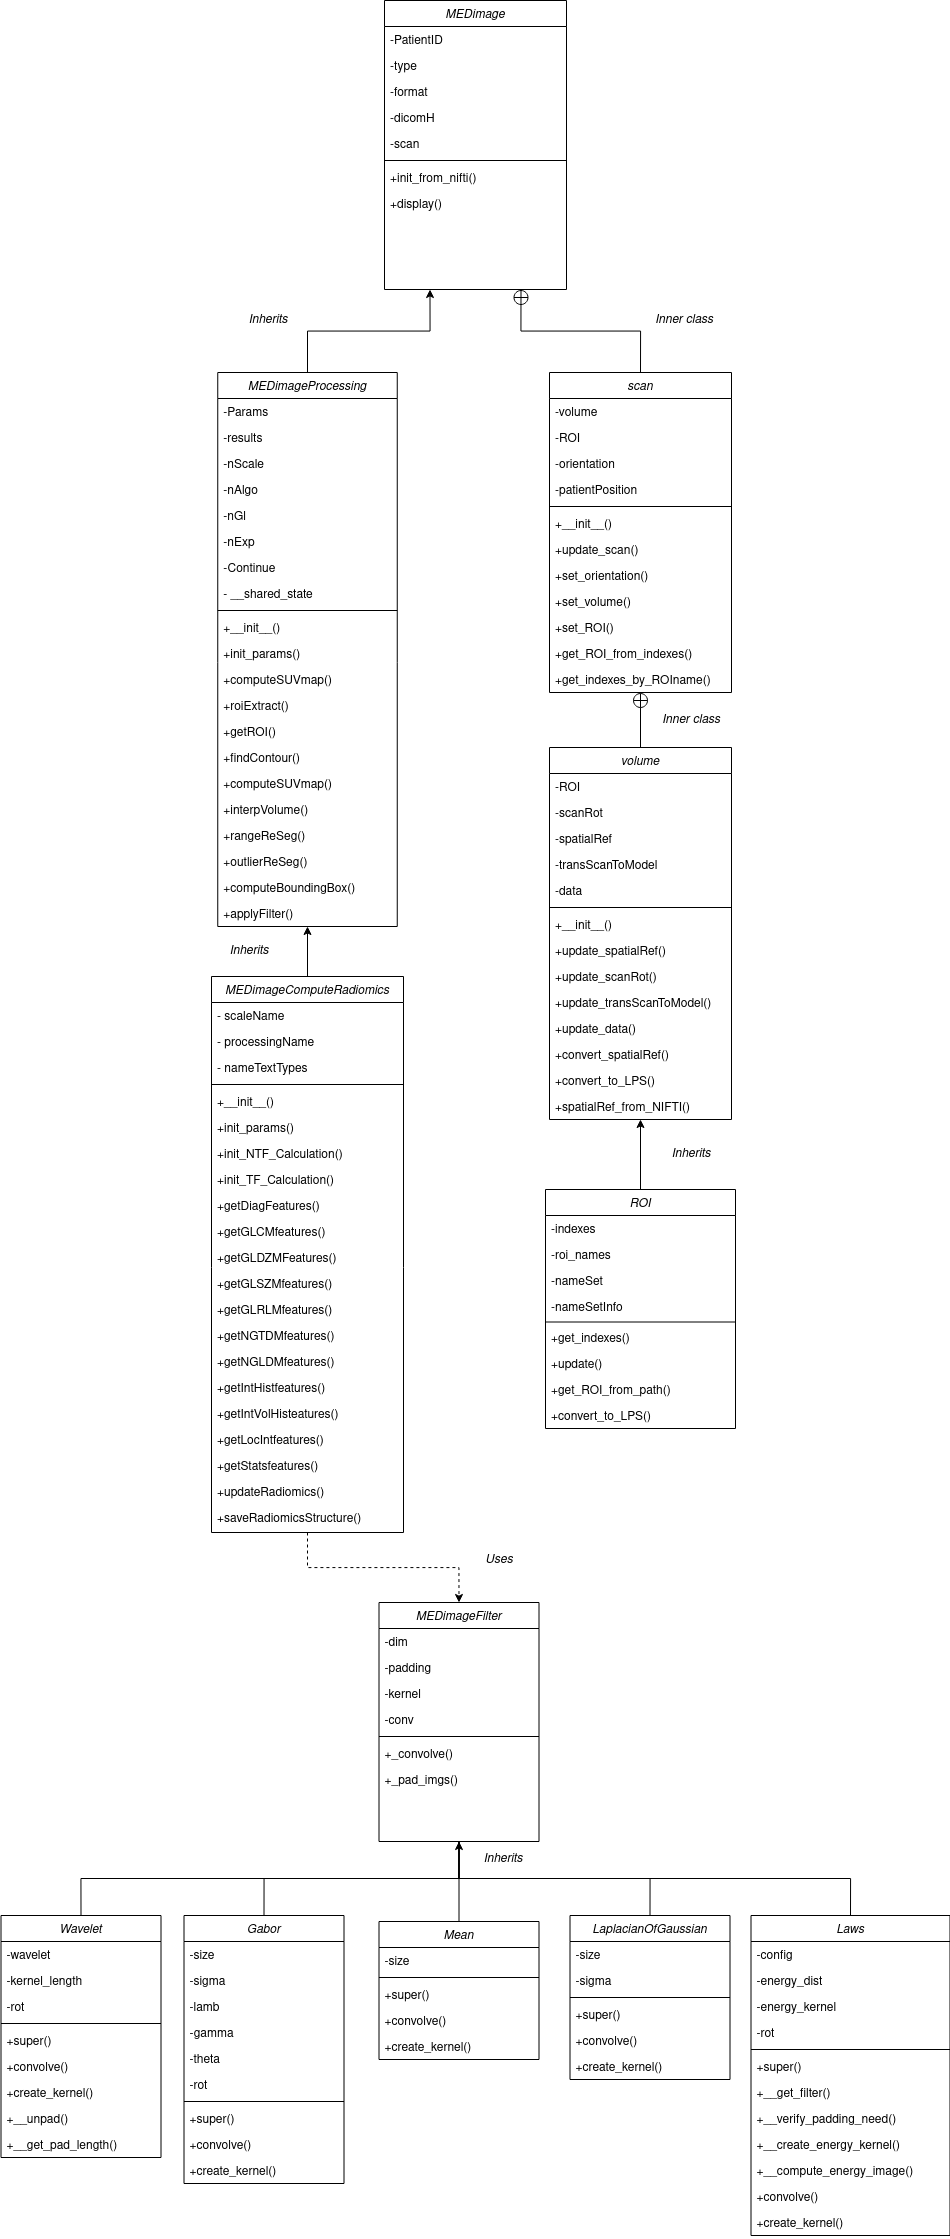

In [1]:
from copy import deepcopy
from pathlib import Path

import os
import sys

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/MEDimage.py'))
sys.path.append(os.path.dirname(MODULE_DIR))

# import MEDimage classes
from MEDimage.MEDimage import MEDimage
from MEDimage.MEDimageComputeRadiomics import MEDimageComputeRadiomics
from MEDimage.MEDimageProcessing import MEDimageProcessing
from MEDimage.utils import jsonUtils

In [2]:
def __processParams(imParams, scanType):
    """
    Process the computation settings.
    
    Args:
        imParams (Dict): JSON with the options that will be used during 
            the image processing and features extraction.
        scanType (str): scan type (Ex: MRscan, CTscan...).
        
    Returns:
        A dict with all the settings for the right scan type.
        
    """
    if scanType == 'MRscan':
        imParams = imParams['imParamMR']
    elif scanType == 'CTscan':
        imParams = imParams['imParamCT']
    elif scanType == 'PTscan':
        imParams = imParams['imParamPET']
    else:
        raise ValueError(r"scanType must be 'MRscan', 'PTscan' or 'CTscan'")
        
    return imParams

## MEDimage initialization

Initializing a *MEDimage* class is easy, as you saw in the class diagram above, the *MEDimage* class can be created from raw data, either DICOM or NIfTI. The DICOM data can be processed and converted to a *MEDimage* class and saved as a [pickle object](https://docs.python.org/3/library/pickle.html) (*npy* format) using the method *processDICOM()* that organizes DICOM files and calls another method *process_dicom_scan_files()* which creates the *MEDimage* class from the given DICOM files. Whereas, for NIfTI files *MEDimage* class can be created using the simple method *initMEDimage()*. Additionally, you can use this method as well to load an already-saved MEDimage instance. In this tuto we will try all theses methods, so we we will need DICOM and NIfTI data. The following figure shows the current folder structure:

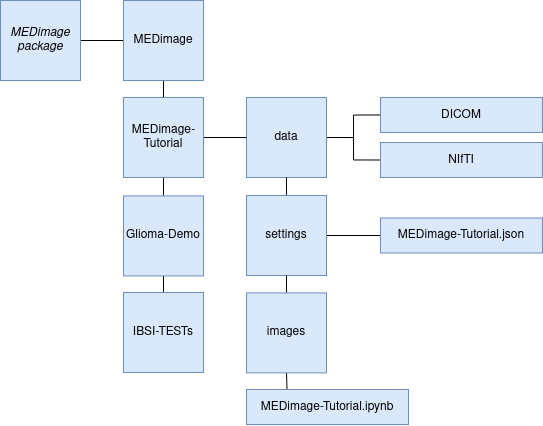

The *data* folder contains data for a single scan: *Glioma-TCGA-02-003*. *DICOM* folder contains multiple dcm files, each file is a slice for the imaging volume and some files are for the RTSTRCUT (Mask data). As for *NIfTI* folder, it contains as well files of the imaging and mask data for the same scan, the filenames should respect the following naming convention:
   - Tumor volume: **PatientID__ImagingScanName(tumorAuto).ImagingModality.nii.gz**
   - ROI mask: **PatientID__ImagingScanName(tumor).ROI.nii.gz**

You will also need to set the MEDimage processing and computation settings before the initialization and organize all of it in a *JSON* file. We will now demonstrate the use of both approaches using a scan/patient i.e. we will initialize a *MEDimage* class using a *npy* file and a *NIfTI* file. You can also take a look at the *JSON* settings file in the folder *settings* to have an idea about the settings needed for processing and computation.

In [3]:
pathData = Path(os.getcwd()) / "data" # Path to the data(scan) folder
pathSettings = Path(os.getcwd()) / "settings" # Path to the script settings
imParams = jsonUtils.loadjson(pathSettings / 'MEDimage-Tutorial.json') # Processing & computation settings
imParams = __processParams(imParams, scanType='MRscan')

Finally, here some information about our scan/patient:
 - **ID**: Glioma-TCGA-02-003
 - **Imaging scan name**: T1
 - **Modality**: MRscan
 - **Regions of interest**:
     - Number of regions: 3
     - Names of ROIs: ED, ET and NET
     - ROI name: {ED}+{ET}+{NET}

In [4]:
NPYnameRead = 'Glioma-TCGA-02-0003__T1.MRscan.npy' # scan file name, npy format
NIfTInameRead = 'Glioma-TCGA-02-0003__T1(tumorAuto).MRscan.nii.gz' # scan file name, NIfTI format
nameROI = '{ED}+{ET}+{NET}' # Region of interest name
roiType = ''
roiType_label = ''

### First approach
Using a *npy* file, a file that already contains a *MEDimage* instance. We will need 4 main arguments for our method *initMEDimage()*:
- nameRead (str): name of the scan that will be used to initialize the MEDimage class and its children.
- pathRead (Path): Path to the scan file.
- roiType (str): ROI type.
- imParams (Dict): Dict of the test parameters.
- log_file (str): Name of the log file that will be used.

**PS**: Since *MEDimageProcessing* inherits from *MEDimage* and *MEDimageComputeRadiomics* inherits from *MEDimageProcessing*, we will only need *MEDimageProcessing* and *MEDimageComputeRadiomics* instances in the tutorial.

In [5]:
from MEDimage.utils.initMEDimage import initMEDimage

MEDimageProcess_npy, MEDimageCR_npy = initMEDimage(NPYnameRead, 
                                           pathData, 
                                           roiType, 
                                           imParams, 
                                           'log_file_MEDimage_tuto.txt')

In [6]:
MEDimageProcess_npy.format

'npy'

### Second approach
Using *NIfTI* files, we will need two files, one contains imaging data and the other contains the ROI mask. Finally, We will need the same arguments for our method *initMEDimage()* (i.e. same arguments but different values)

**PS**: Since *MEDimageProcessing* inherits from *MEDimage* and *MEDimageComputeRadiomics* inherits from *MEDimageProcessing*, we will only need *MEDimageProcessing* and *MEDimageComputeRadiomics* instances in the tutorial.

In [7]:
# we use deepcopy so we can have two MEDimage instances at the same time (npy instance and NIfTI instance).
MEDimageProcess_npy = deepcopy(MEDimageProcess_npy)
MEDimageCR_npy = deepcopy(MEDimageCR_npy)

In [8]:
from MEDimage.utils.initMEDimage import initMEDimage

MEDimageProcess_nifti, MEDimageCR_nifti = initMEDimage(NIfTInameRead, 
                                           pathData, 
                                           roiType, 
                                           imParams, 
                                           'log_file_MEDimage_tuto.txt')

## MEDimage exploration

We have now initialized *MEDimage* successfully, let's have fun exploring the class attributes for both approaches. The *MEDimage* attributes are as follows:
- *PatientID*
- *type*
- *format*
- *dicomH*
- *scan*

We are going to explore each and every attribute

###  - Patient ID
A special identification string for each patient/scan.

In [9]:
MEDimageProcess_nifti.patientID

'Glioma-TCGA-02-0003'

In [10]:
MEDimageProcess_npy.patientID

'Glioma-TCGA-02-0003'

###  - Type
Scan type, usually: *MRscan*, *CTscan*, *PETscan*...

In [11]:
MEDimageProcess_nifti.type

'MRscan'

In [12]:
MEDimageProcess_npy.type

'MRscan'

###  - Format
The format used to initialize the current *MEDimage* class

In [13]:
MEDimageProcess_npy.format

'npy'

In [14]:
MEDimageProcess_nifti.format

'nifti'

As we can see the format is not the same for both instances since we used different formats for initialization.

###  - scan (inner class)
A *MEDimage* inner class that holds all the imaging data (volume and ROI) and other important information. It has the following attributes:
- *orientation*: Imaging data anatomical plane (sagittal plane, coronal plane or axial plane)
- *patientPosition*: Position of the patient relative to the imaging equipment space (HFS, HFP...)

In [15]:
MEDimageProcess_nifti.scan.orientation

'Axial'

In [16]:
MEDimageProcess_nifti.scan.patientPosition

'HFS'

- volume : A *scan* inner class that holds imaging volume data and other information. It has the following attributes:
    - *spatialRef*: same functionality of [MATLAB imref3d class](https://www.mathworks.com/help/images/ref/imref3d.html).
    - *scanRot*: array of the rotation applied to the imaging data (if that's the case)
    - *data*: Array of the imaging data

Little exploration of the *data* attribute

In [17]:
# volume data
MEDimageProcess_nifti.scan.volume.data.shape

(240, 240, 155)

And we can visualize this data using the *display()* method

<Figure size 432x288 with 0 Axes>

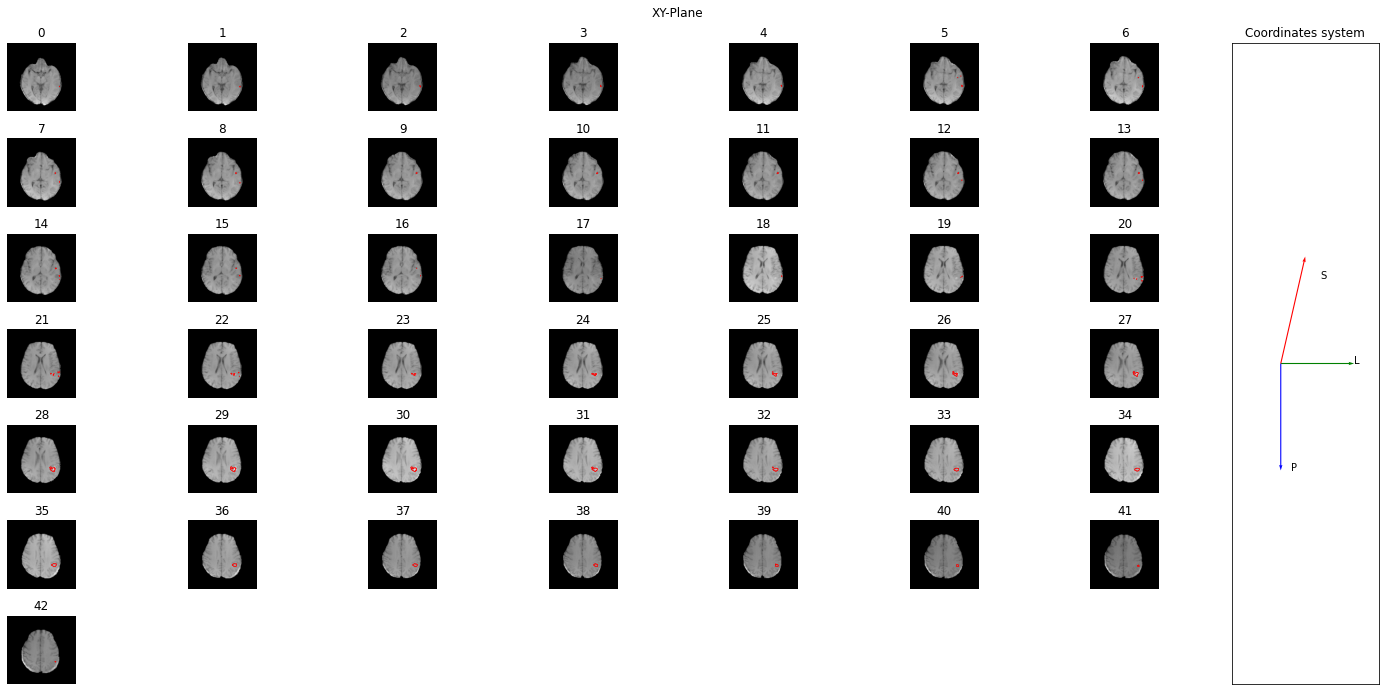

In [18]:
MEDimageProcess_npy.display()

You can plot only one slice using the same method *display()* by specifying the index of the slice

<Figure size 432x288 with 0 Axes>

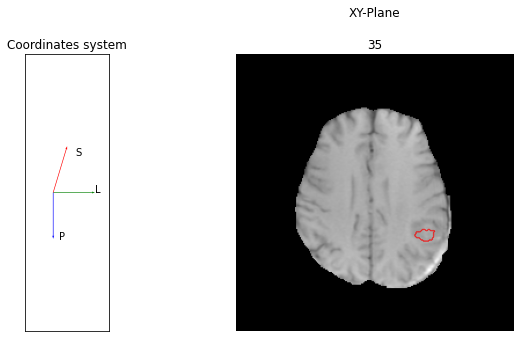

In [19]:
MEDimageProcess_npy.display(35)

Let's check if the volume imaging data is the same for both formats (*npy* and *NIfTI*)

In [20]:
MEDimageProcess_nifti.scan.volume.data.all() == MEDimageProcess_npy.scan.volume.data.all()

True

*scanRot* attribute

In [21]:
# scan rotation (usually None)
MEDimageProcess_nifti.scan.volume.scanRot

*SpatialRef* exploration

Span of image in the x-dimension in the world coordinate system

In [22]:
MEDimageProcess_nifti.scan.volume.spatialRef.ImageExtentInWorldX

240.0

Spatial Reference: Span of image in the y-dimension in the world coordinate system

In [23]:
MEDimageProcess_nifti.scan.volume.spatialRef.ImageExtentInWorldY

240.0

Spatial Reference: Span of image in the z-dimension in the world coordinate system

In [24]:
MEDimageProcess_nifti.scan.volume.spatialRef.ImageExtentInWorldZ

155.0

- ROI : A *scan* inner class that holds mask data and other information. It has the following attributes:
    - *indexes*: Dict of the ROI indexes for each ROI name.
    - *roi_names*: Dict of the ROI names for the imaging data.
    - *nameSet* (Not crucial for features extraction): Dict of the User-defined name for Structure Set for each ROI name.
    - nameSetInfo* (Not crucial for features extraction): Dict of the names of the structure sets that define the areas of significance. Either 'StructureSetName', 'StructureSetDescription', 'SeriesDescription' or 'SeriesInstanceUID'.

*indexes*: the indexes are just integers that point to the region of interest. For each ROI name we have a list of indexes. For our case we have 3 ROIs: *ED*, *ET* and *NET* so that makes three lists of ROI indexes. Let's see what that looks like in the code (we should have a *dict* of size 3)

In [25]:
MEDimageProcess_nifti.scan.ROI.indexes

{'0': (array([5565983, 5565984, 5565985, ..., 6830775, 6830930, 6831086]),),
 '1': (array([5528627, 5528628, 5528629, ..., 6831540, 6831541, 6869197]),),
 '2': (array([5195371, 5195526, 5232100, ..., 6906568, 6906721, 6906722]),)}

As mentioned in the introduction, the ROI names are : *ED*, *ET* and *NET*, we must have the same names in our class instance, let's check...

In [26]:
MEDimageProcess_nifti.scan.ROI.roi_names

{'0': 'ET', '1': 'ED', '2': 'NET'}

Finally, the two final attributes are *nameSet* and *nameSetInfo* are not used in any part of the code and are here for description.

In [27]:
MEDimageProcess_nifti.scan.ROI.nameSet

{'0': 'T1', '1': 'T1', '2': 'T1'}

In [28]:
MEDimageProcess_nifti.scan.ROI.nameSetInfo

{}

Let's try to change the value of some attributes, for example: we would like to change the ROI name for index *2*, which means we will replace *'NET'* with *'tumor'* 

In [29]:
MEDimageProcess_nifti.scan.ROI.update_ROIname(2, 'tumor')
MEDimageProcess_nifti.scan.ROI.roi_names

{'0': 'ET', '1': 'ED', '2': 'tumor'}

You can update every class attribute value using the right class methods for that (check the class diagram above)